# Imports and Initial Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
)
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [2]:
data = pd.read_csv("./healthcare-dataset-stroke-data.csv")

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
for col in data.select_dtypes(include="object").columns :
    data[col] = data[col].astype("category")
data = data.drop(columns=["id"])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5110 non-null   category
 1   age                5110 non-null   float64 
 2   hypertension       5110 non-null   int64   
 3   heart_disease      5110 non-null   int64   
 4   ever_married       5110 non-null   category
 5   work_type          5110 non-null   category
 6   Residence_type     5110 non-null   category
 7   avg_glucose_level  5110 non-null   float64 
 8   bmi                4909 non-null   float64 
 9   smoking_status     5110 non-null   category
 10  stroke             5110 non-null   int64   
dtypes: category(5), float64(3), int64(3)
memory usage: 265.4 KB


| Feature             | Type               | Description                           | Possible Values / Format                                           | Explanation / Notes                                               |
| ------------------- | ------------------ | ------------------------------------- | ------------------------------------------------------------------ | -----------------------------------
| `gender`            | Categorical        | Biological sex of the patient         | `Male`, `Female`                                                   | Can be used as a feature; may need encoding for ML models         |
| `age`               | Numerical          | Age of the patient in years           | Float                                                              | Important risk factor for stroke; higher age often increases risk |
| `hypertension`      | Categorical/Binary | Whether patient has hypertension      | `0` (No), `1` (Yes)                                                | Hypertension is a key stroke risk factor                          |
| `heart_disease`     | Categorical/Binary | Whether patient has any heart disease | `0` (No), `1` (Yes)                                                | Another major risk factor for stroke                              |
| `ever_married`      | Categorical        | Marital status                        | `Yes`, `No`                                                        | Could correlate with lifestyle or social support                  |
| `work_type`         | Categorical        | Type of occupation                    | `Private`, `Self-employed`, `Govt_job`, `Children`, `Never_worked` | Can reflect lifestyle and stress levels                           |
| `Residence_type`    | Categorical        | Urban or rural living area            | `Urban`, `Rural`                                                   | Can affect access to healthcare and lifestyle patterns            |
| `avg_glucose_level` | Numerical          | Average blood glucose level (mg/dL)   | Float                                                              | High glucose/diabetes increases stroke risk                       |
| `bmi`               | Numerical          | Body Mass Index                       | Float (may contain NaN)                                            | Obesity is a risk factor; missing values may need imputation      |
| `smoking_status`    | Categorical        | Smoking habits                        | `never smoked`, `formerly smoked`, `smokes`, `Unknown`             | Smoking is a major risk factor; `Unknown` needs special handling  |
| `stroke`            | Categorical/Binary | Whether patient has had a stroke      | `0` (No), `1` (Yes)                                                | Target variable for prediction                                    |


In [7]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Unvalidated values 

> The minimum value of the age column is 0.008 years , which is suspicious

(array([434., 362., 440., 484., 597., 583., 686., 559., 407., 558.]),
 array([8.0000e-02, 8.2720e+00, 1.6464e+01, 2.4656e+01, 3.2848e+01,
        4.1040e+01, 4.9232e+01, 5.7424e+01, 6.5616e+01, 7.3808e+01,
        8.2000e+01]),
 <BarContainer object of 10 artists>)

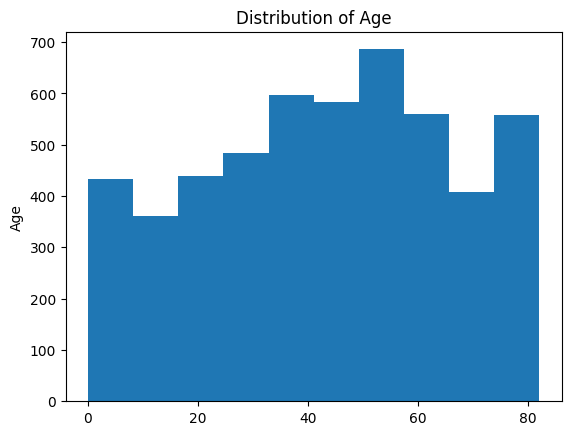

In [8]:
plt.title("Distribution of Age")
plt.ylabel("Age")
plt.hist(data["age"])

In [9]:
data[data["age"]<=1]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
363,Female,0.64,0,0,No,children,Urban,83.82,24.9,Unknown,0
376,Female,0.88,0,0,No,children,Rural,88.11,15.5,Unknown,0
564,Female,0.32,0,0,No,children,Rural,73.71,16.2,Unknown,0
844,Male,1.00,0,0,No,children,Rural,89.30,21.4,Unknown,0
951,Male,1.00,0,0,No,children,Rural,123.21,15.1,Unknown,0
982,Male,0.88,0,0,No,children,Rural,157.57,19.2,Unknown,0
996,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
1093,Female,0.32,0,0,No,children,Rural,55.86,16.0,Unknown,0
1206,Female,0.72,0,0,No,children,Urban,66.36,23.0,Unknown,0
1317,Male,0.80,0,0,No,children,Rural,98.67,17.5,Unknown,0


> 💡 Upon examining the dataset, the small age values (e.g., 0.08, 0.16, 0.32 years) correspond to children under 1 year old.


# Data Cleaning & Feature Engineering + Visualizations

## NaN Values

In [10]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

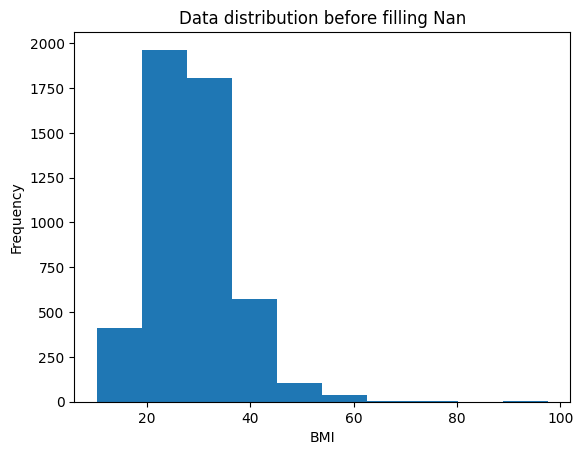

In [11]:
plt.title("Data distribution before filling Nan")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.hist(data["bmi"])
plt.show()

### Fill NaN with median since the data distribution is skewed

In [12]:
data["bmi"] = data["bmi"].fillna(data["bmi"].median())

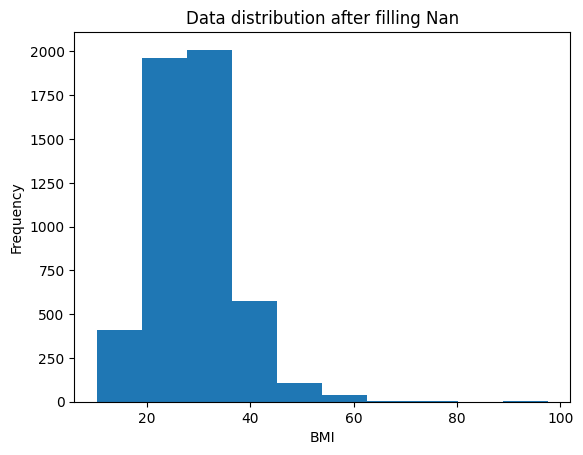

In [13]:
plt.title("Data distribution after filling Nan")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.hist(data["bmi"])
plt.show()

In [14]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Duplicated Values

In [15]:
print("Total number of duplicated rows: ", data.duplicated().sum())

Total number of duplicated rows:  0


## Detecting Outliers

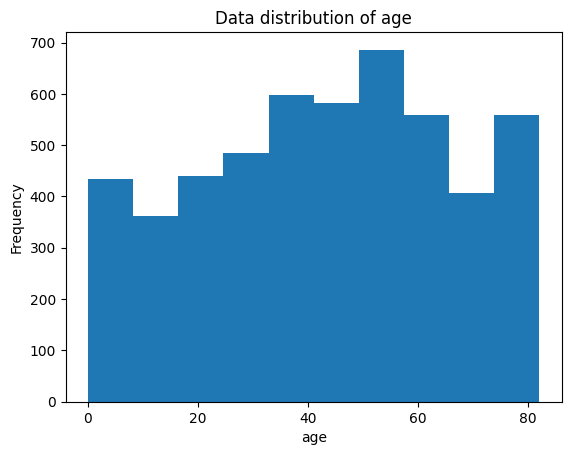

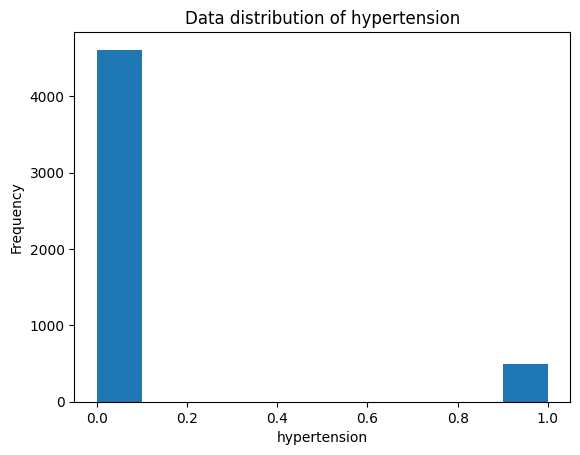

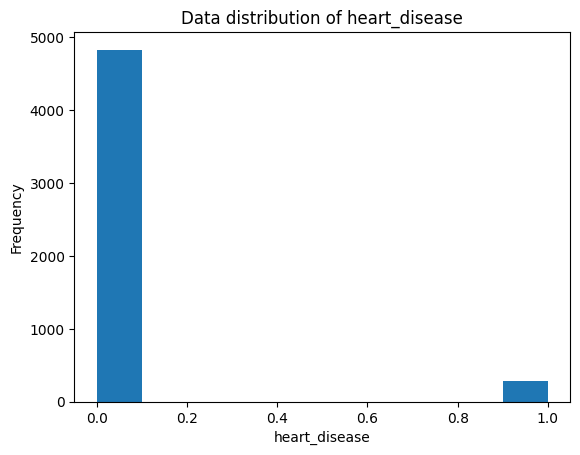

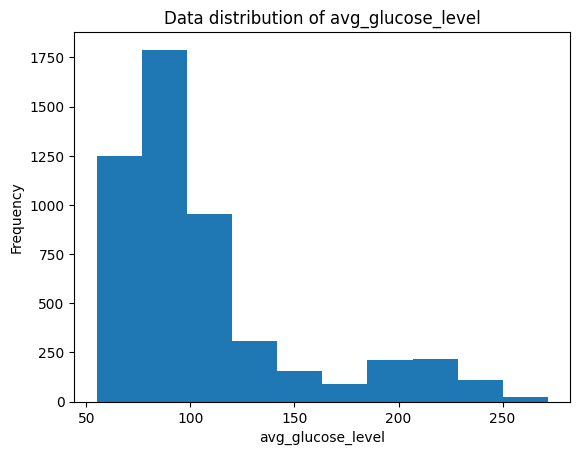

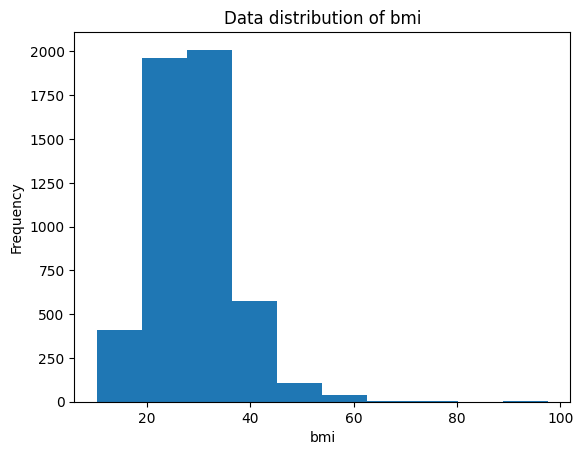

In [16]:
for col in data.drop(columns=["stroke"]).select_dtypes("number").columns:
    plt.figure()  
    plt.title(f"Data distribution of {col}")
    plt.hist(data[col])  
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

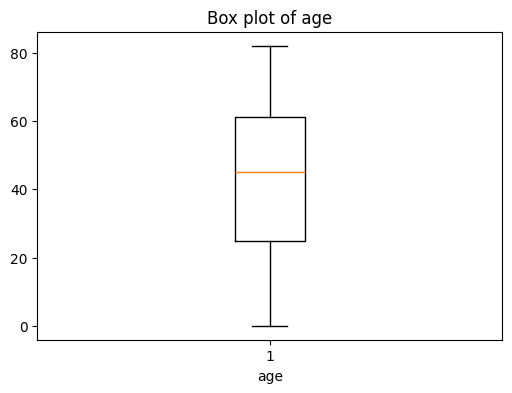

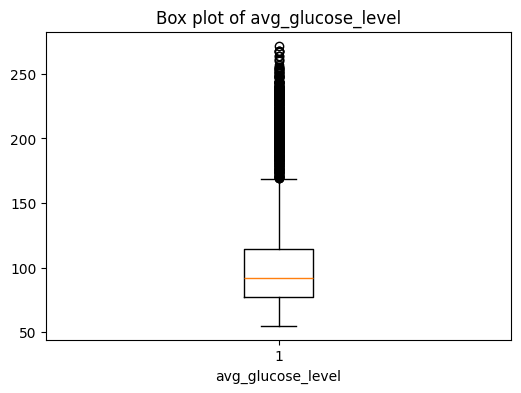

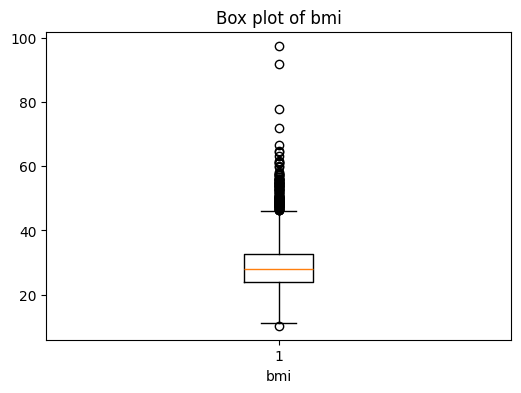

In [17]:
numeric_cols = data.drop(columns=["hypertension", "heart_disease", "stroke"]).select_dtypes(include="number").columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))  
    plt.title(f"Box plot of {col}")
    plt.boxplot(data[col])
    plt.xlabel(col)
    plt.show()


> 💡 Although there are some outliers in bmi and avg_glucose_level, We will primarily use tree-based models (e.g., Random Forest, XGBoost, CatBoost), which are naturally robust to outliers. Therefore, these extreme values will be retained, as they may carry important information for predicting stroke.

### Data Cleaning Based on Counterfactual Analysis

Upon examining the dataset and generated counterfactuals, we identified **two types of clinically implausible cases**:

1. **Extremely low glucose levels** – Some counterfactuals suggested that lowering glucose would increase stroke risk. This is **not supported by medical evidence** and occurs only in a small subset of patients (rare outliers).  

2. **Extremely high BMI values (≥ 50)** – A few instances indicated that very high BMI decreases stroke risk, which is **clinically unrealistic** and also represents a small portion of the dataset.  

Given that these cases are rare and potentially misleading, it is reasonable to remove them to **improve the plausibility and reliability** of subsequent analyses.


In [18]:
# Remove rows where avg_glucose_level <= 70 AND stroke == 1
data = data[~((data['avg_glucose_level'] <= 70) & (data['stroke'] == 1))]
data = data[~(data['bmi'] >= 50)]

## Imbalanced target classes

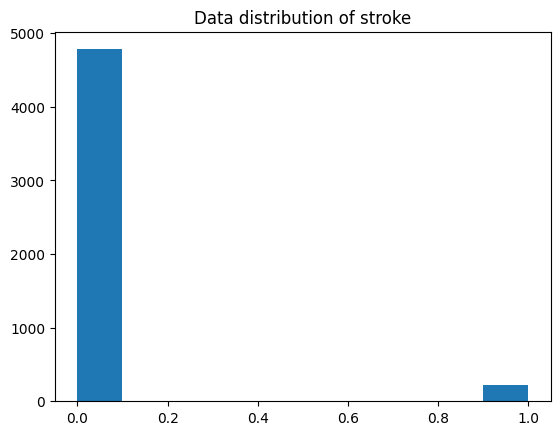

In [19]:
plt.title("Data distribution of stroke")
plt.hist(data["stroke"])
plt.show()

### So the target value is highly imbalanced. I will using SMOTE to oversampling the minority class.

In [20]:
data.select_dtypes("number").corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.278523,0.264197,0.243049,0.364870,0.235834
hypertension,0.278523,1.000000,0.112829,0.175750,0.148233,0.123377
heart_disease,0.264197,0.112829,1.000000,0.170209,0.055346,0.133358
avg_glucose_level,0.243049,0.175750,0.170209,1.000000,0.174595,0.164977
bmi,0.364870,0.148233,0.055346,0.174595,1.000000,0.048217
stroke,0.235834,0.123377,0.133358,0.164977,0.048217,1.000000


# Building models

## Preprocessing

In [21]:
category_mappings = {}
dataForModel = data.copy()
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    dataForModel[col] = dataForModel[col].astype('category')
    category_mappings[col] = dict(enumerate(dataForModel[col].cat.categories))
    dataForModel[col] = dataForModel[col].cat.codes

X = dataForModel.drop(columns="stroke")
y = dataForModel["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [22]:
category_mappings

{'gender': {0: 'Female', 1: 'Male', 2: 'Other'},
 'ever_married': {0: 'No', 1: 'Yes'},
 'work_type': {0: 'Govt_job',
  1: 'Never_worked',
  2: 'Private',
  3: 'Self-employed',
  4: 'children'},
 'Residence_type': {0: 'Rural', 1: 'Urban'},
 'smoking_status': {0: 'Unknown',
  1: 'formerly smoked',
  2: 'never smoked',
  3: 'smokes'}}

### SMOTE

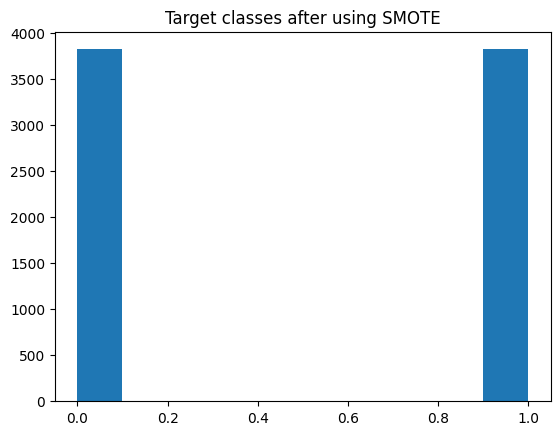

In [23]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

plt.hist(y_train_res)
plt.title("Target classes after using SMOTE")
plt.show()

### Function to calculate metrics

In [24]:

def evaluate_model(y_true, y_pred, y_proba):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6,5))
    sn.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues",
        xticklabels=["Predicted No Stroke", "Predicted Stroke"],
        yticklabels=["Actual No Stroke", "Actual Stroke"]
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

## Random forest 

#### Tunning hyperparameters

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found: {'class_weight': {0: 1, 1: 10}, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best recall score: 0.9984317138517722
===== Random Forest (Grid Search) =====
Accuracy: 0.5194805194805194
Precision: 0.0838095238095238
Recall: 1.0
F1-Score: 0.1546572934973638
ROC-AUC: 0.8448275862068965

Confusion Matrix:
[[476 481]
 [  0  44]]


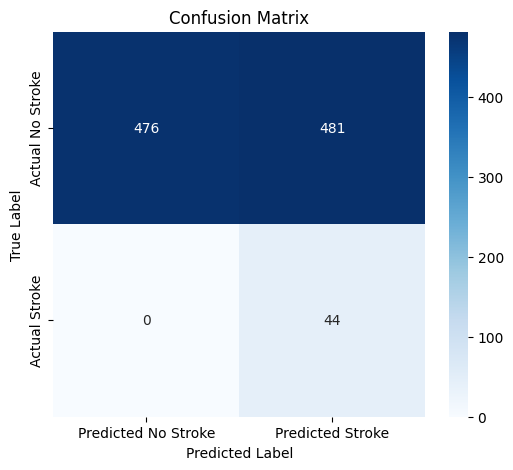


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.66       957
           1       0.08      1.00      0.15        44

    accuracy                           0.52      1001
   macro avg       0.54      0.75      0.41      1001
weighted avg       0.96      0.52      0.64      1001



In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 500],      # number of trees
    'max_depth': [None, 5, 10, 20],      # max depth of tree
    'min_samples_split': [2, 5, 10],     # min samples to split
    'min_samples_leaf': [1, 2, 4],       # min samples per leaf
    'class_weight': ['balanced', {0:1,1:5}, {0:1,1:10}]  # emphasize minority
}


rf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',  # maximize recall for minority class
    cv=5,
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train_res, y_train_res)

print("Best parameters found:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

print("===== Random Forest (Grid Search) =====")
evaluate_model(y_test, y_pred_rf, y_proba_rf)


#### Using tunned hyperparameters

===== Random Forest =====
Accuracy: 0.6713286713286714
Precision: 0.11382113821138211
Recall: 0.9545454545454546
F1-Score: 0.2033898305084746
ROC-AUC: 0.8591954022988506

Confusion Matrix:
[[630 327]
 [  2  42]]


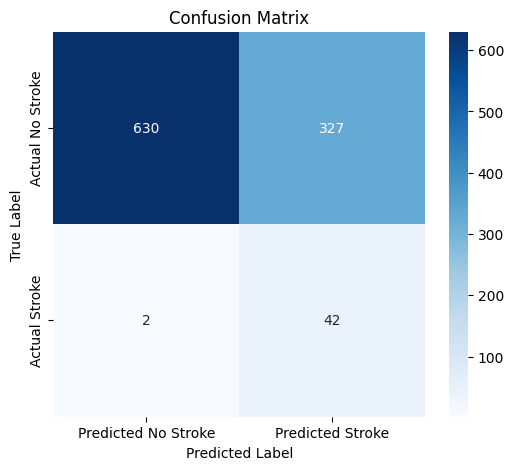


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.79       957
           1       0.11      0.95      0.20        44

    accuracy                           0.67      1001
   macro avg       0.56      0.81      0.50      1001
weighted avg       0.96      0.67      0.77      1001



In [26]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=1,
    class_weight={0: 1, 1: 2},  
    random_state=42
)


rf.fit(X_train_res, y_train_res)


y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]


print("===== Random Forest =====")
evaluate_model(y_test, y_pred_rf, y_proba_rf)


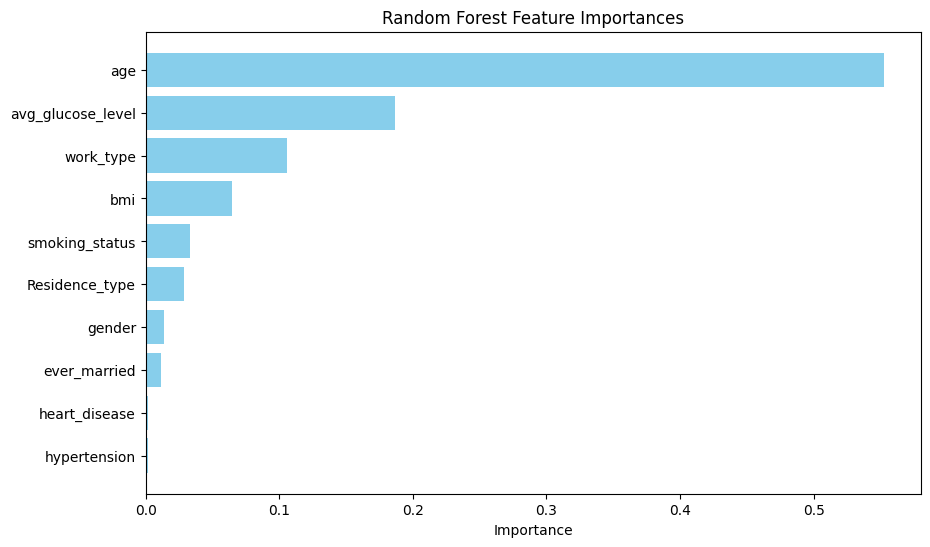

In [27]:
feature_importances = pd.DataFrame({
    'feature': X_train_res.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=True)  # ascending for horizontal bar

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()


## XGboost 

c:\Users\chandarana\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:01:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== XGBoost =====
Accuracy: 0.5924075924075924
Precision: 0.09375
Recall: 0.9545454545454546
F1-Score: 0.17073170731707318
ROC-AUC: 0.851619644723093

Confusion Matrix:
[[551 406]
 [  2  42]]


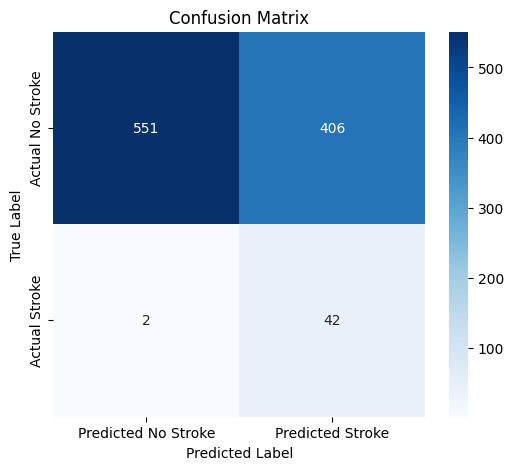


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.58      0.73       957
           1       0.09      0.95      0.17        44

    accuracy                           0.59      1001
   macro avg       0.55      0.77      0.45      1001
weighted avg       0.96      0.59      0.71      1001



In [28]:
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()  # original ratio
scale_pos_weight_tuned = scale_pos_weight * 1.5  # increase weight for minority
xgb = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=1000,
    scale_pos_weight=scale_pos_weight_tuned,  # incresing weight for minority class
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("===== XGBoost =====")
evaluate_model(y_test, y_pred_xgb, y_proba_xgb)

## Catboost

0:	learn: 1.0000000	total: 97ms	remaining: 48.4s
100:	learn: 1.0000000	total: 3.08s	remaining: 12.2s
200:	learn: 1.0000000	total: 6.08s	remaining: 9.04s
300:	learn: 1.0000000	total: 9.37s	remaining: 6.19s
400:	learn: 1.0000000	total: 12.4s	remaining: 3.06s
499:	learn: 1.0000000	total: 15.3s	remaining: 0us
----Catboost-------
Accuracy: 0.6703296703296703
Precision: 0.11141304347826086
Recall: 0.9318181818181818
F1-Score: 0.19902912621359223
ROC-AUC: 0.8591954022988506

Confusion Matrix:
[[630 327]
 [  3  41]]


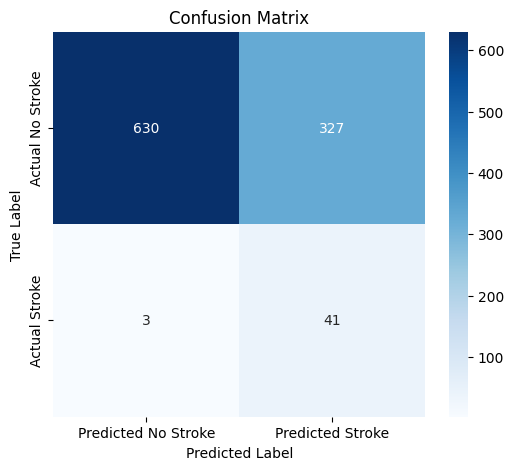


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.79       957
           1       0.11      0.93      0.20        44

    accuracy                           0.67      1001
   macro avg       0.55      0.80      0.50      1001
weighted avg       0.96      0.67      0.77      1001



In [29]:
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()  # original ratio
scale_pos_weight_tuned = scale_pos_weight * 1.5  # increase weight for minority
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Prepare Pool object for CatBoost (categorical features are indexed)
cat_features_indices = [X_train_res.columns.get_loc(c) for c in categorical_cols]

catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='Recall',
    scale_pos_weight=scale_pos_weight_tuned,# incresing weight for minority class
    random_state=42,
    verbose=100
)

catboost_model.fit(
    X_train_res, y_train_res,
    cat_features=cat_features_indices
)

y_pred = catboost_model.predict(X_test)
y_proba = catboost_model.predict_proba(X_test)[:,1]


print("----Catboost-------")
evaluate_model(y_test, y_pred, y_proba)


> 🌟 We observed that after removing those outliers(avg_glucose_level <=70 but stroke = 1) , we can we that our recall increase significantly 

> 💡 In conclusion, for healthcare applications, recall is prioritized over precision because false negatives are far more dangerous than false positives. Accepting lower precision is justified in order to ensure that critical cases are not missed.

## Explainable Insights

In [30]:
categorical_maps = {
    'gender': {0: 'Female', 1: 'Male', 2: 'Other'},
    'ever_married': {0: 'No', 1: 'Yes'},
    'work_type': {0: 'Govt_job', 1: 'Never_worked', 2: 'Private', 3: 'Self-employed', 4: 'children'},
    'Residence_type': {0: 'Rural', 1: 'Urban'},
    'smoking_status': {0: 'Unknown', 1: 'formerly smoked', 2: 'never smoked', 3: 'smokes'}
}

In [31]:
## Map the catetory to human-readable
def transformCategory(df):
    df_copy = df.copy()  # avoid modifying original
    for col, mapping in categorical_maps.items():
        if col in df_copy.columns:  
            df_copy[col] = df_copy[col].map(mapping)
    return df_copy

In [32]:
# %pip install dice-ml -q
import dice_ml

d = dice_ml.Data(dataframe=X_train_res.assign(target=y_train_res),
                  continuous_features=['age', 'avg_glucose_level', "bmi"],  
                  outcome_name='target')  

m = dice_ml.Model(model=rf, backend='sklearn')  
exp = dice_ml.Dice(d, m, method='random')  

# 4. Generate counterfactuals
query_instance = X_test.iloc[4:5]  # can change this 
cf = exp.generate_counterfactuals(query_instance, total_CFs=3, desired_class="opposite")
cf_df = cf.cf_examples_list[0].final_cfs_df  

transformCategory(cf_df)

  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\chandarana\AppData\Local\Programs\Python\Python311\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
c:\Users\chandarana\AppData\Local\Programs\Python\Python311\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
c:\Users\chandarana\AppData\Local\Programs\Python\Python311\Lib\site-pack

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,target
0,Female,50.6,0,0,Yes,Private,Urban,71.4,28.4,smokes,1
1,Female,52.9,0,0,Yes,Private,Urban,71.4,28.4,smokes,1
2,Female,62.4,0,0,Yes,Private,Urban,71.4,28.4,smokes,1


In [33]:
predicted_target = rf.predict(query_instance)  
query_instance.loc[:, "target"] = predicted_target
transformCategory(query_instance)

C:\Users\chandarana\AppData\Local\Temp\ipykernel_31200\3643898812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_instance.loc[:, "target"] = predicted_target


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,target
4812,Female,45.0,0,0,Yes,Private,Urban,71.4,28.4,smokes,0


In [34]:
transformCategory(cf_df)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,target
0,Female,50.6,0,0,Yes,Private,Urban,71.4,28.4,smokes,1
1,Female,52.9,0,0,Yes,Private,Urban,71.4,28.4,smokes,1
2,Female,62.4,0,0,Yes,Private,Urban,71.4,28.4,smokes,1


# Counterfactual Analysis

## Generating Counter Factuals

### 1/

We analyzed counterfactuals for a patient profile:

| Gender | Age | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|-----|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Female | 43  | No           | No            | Yes     | Private   | Urban     | 86.67       | 33.3 | never smoked   | 0      |

The model-generated counterfactuals for this patient are:

| Gender | Age | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|-----|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Female | 43  | 0            | 0             | Yes     | Private   | Urban     | 110.87      | 33.3 | formerly smoked | 1      |
| Female | 43  | 0            | 0             | Yes     | Private   | Urban     | 69.48       | 33.3 | never smoked   | 1      |
| Female | 43  | 0            | 0             | Yes     | Private   | Urban     | 60.55       | 33.3 | never smoked   | 1      |

### Interpretation

1. **Target change:** All counterfactuals flip the predicted stroke from 0 → 1.  
2. **Feature changes:** Only the **average glucose level** and **smoking status** vary significantly.  
3. **Unrealistic pattern:**  
   - Two counterfactuals suggest that **lowering average glucose level (69.48, 60.55)** increases stroke risk.  
   - This is **not clinically plausible**, as lower glucose does not increase stroke probability.  

### Actionable insight

- This highlights that the model may have learned **spurious relationships** from rare cases.  
- To generate **meaningful and medically realistic counterfactuals**, extreme or low-probability feature values should be filtered out during analysis.



In [35]:
print(data['stroke'][(data["avg_glucose_level"]<=70) & (data['stroke'] == 1)].count() / data['stroke'][(data["avg_glucose_level"]<=70) & (data['stroke'] == 0)].count() * 100)

0.0


> Go deeper we can see that the case that the patient has **avg_glucose_level <= 70** and has stroke is only **3,7%**. So for more reasonable analysis, we should consider those as outliers

### 2/

We examined counterfactuals for the following patient profile:

| Gender | Age | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|-----|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Male   | 17  | No           | No            | No      | Govt_job  | Urban     | 68.91       | 23.0 | Unknown        | 0      |

After removing extreme or unrealistic outliers (e.g., extremely low or high glucose levels), the model-generated counterfactuals are:

| Gender | Age  | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|------|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Male   | 76.6 | 0            | 0             | No      | Govt_job  | Urban     | 222.16      | 23.0 | Unknown        | 1      |
| Male   | 57.1 | 0            | 0             | No      | Govt_job  | Urban     | 179.49      | 23.0 | Unknown        | 1      |
| Male   | 65.8 | 0            | 0             | No      | Govt_job  | Urban     | 227.21      | 23.0 | Unknown        | 1      |

### Interpretation

1. **Target change:** All counterfactuals flip the predicted stroke from 0 → 1.  
2. **Feature changes:** The primary changes are in **age** and **average glucose level**, which increase in the CFs.  
3. **Reasonable pattern:**  
   - Older age and higher glucose levels are associated with increased stroke risk.  
   - This aligns with clinical expectations and literature.  

### Actionable insight

- By removing outliers from the dataset, the counterfactuals now reflect **plausible and medically meaningful scenarios**.  
- This demonstrates that careful preprocessing (outlier removal) is essential for **trustworthy counterfactual explanations** in healthcare models.


### 3/

Original patient profile:

| Gender | Age | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|-----|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Female | 5   | No           | No            | No      | children  | Rural     | 102.04      | 18.5 | Unknown        | 0      |

Counterfactuals generated:

| Gender | Age  | Hypertension | Heart Disease | Married | Work Type   | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|------|--------------|---------------|---------|------------|-----------|-------------|------|----------------|--------|
| Female | 49.9 | 0            | 0             | No      | Private    | Rural     | 102.04      | 18.5 | Unknown        | 1      |
| Female | 74.4 | 0            | 0             | No      | Never_worked | Rural   | 102.04      | 18.5 | Unknown        | 1      |
| Female | 76.3 | 0            | 0             | No      | Govt_job   | Rural     | 102.04      | 18.5 | Unknown        | 1      |

### Interpretation

1. **Target change:** All counterfactuals flip stroke prediction from 0 → 1.  
2. **Feature changes:** The main changes are **age** and **work type**, while glucose and BMI remain constant.  
3. **Insight:**  
   - Even at low BMI and normal glucose levels, older age and occupational stress factors (work type) increase predicted stroke risk.  
   - This suggests that **stress-related factors might be important contributors** to stroke risk in the model.  

### Actionable insight

- Counterfactual analysis highlights that **non-traditional risk factors** such as age-related stress and occupational exposure can strongly influence predicted stroke risk.  
- Proper handling of stress and lifestyle factors is crucial, especially for individuals in high-risk age groups.


### 4/

**Original patient profile:**  

| Gender | Age  | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI  | Smoking Status | Target |
|--------|------|--------------|---------------|---------|-----------|-----------|-------------|------|----------------|--------|
| Male   | 61.0 | 1            | 1             | Yes     | Govt_job  | Rural     | 86.06       | 34.8 | never smoked   | 1      |

**Counterfactuals generated:**  

| Gender | Age  | Hypertension | Heart Disease | Married | Work Type | Residence | Avg Glucose | BMI   | Smoking Status | Target |
|--------|------|--------------|---------------|---------|-----------|-----------|-------------|-------|----------------|--------|
| Male   | 61.0 | 1            | 1             | Yes     | children  | Rural     | 86.06       | 96.1  | never smoked   | 0      |
| Male   | 32.9 | 1            | 1             | Yes     | Govt_job  | Rural     | 86.06       | 34.8  | never smoked   | 0      |
| Male   | 61.0 | 1            | 1             | Yes     | Govt_job  | Rural     | 67.00       | 34.8  | never smoked   | 0      |

### Interpretation

1. **Target change:** All counterfactuals flip stroke prediction from 1 → 0.  
2. **Feature changes and plausibility:**  
   - The most notable change is **BMI = 96.1** in one counterfactual, which is **clinically implausible**.  
3. **Insight:**  
   - The model appears **overly sensitive to extreme BMI increases**, which can artificially reduce predicted stroke risk.  
   
### Actionable insight

- Counterfactual analysis reveals that **extreme BMI changes dominate the model’s predictions**, but these are **not realistic**.  
- For meaningful interpretation, **filtering out implausible counterfactuals** is necessary.  



In [36]:
data[(data['bmi']>=50) & (data['stroke']==1)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [ ]:
data[(data['bmi']>=50) & (data['stroke']==0)]

#### Upon examining the dataset and generated counterfactuals, we observed several instances with **extremely high BMI values (≥ 50)** that produce unrealistic or implausible predictions. Due to the dataset's high class imbalance, although higher BMI should generally increase stroke risk, the majority of these high-BMI instances have **stroke = 0**, which skews the model’s behavior. These instances can be considered **outliers**, and since they represent a small portion of the data, it is reasonable to remove them to improve the plausibility and reliability of subsequent analyses.


# LIME

In [ ]:
%pip install dice-ml -q
%pip install interpret -q
%pip install lime -q

import lime
import lime.lime_tabular
from interpret.blackbox import LimeTabular
from interpret import show

In [ ]:
# Applying LIME
lime = LimeTabular(predict_fn=rf.predict_proba, 
                   data=X_train_res.values,
                   random_state=1)

# Getting local explanations
lime_local = lime.explain_local(X_test[-20:],
                                y_test[-20:],
                                name="LIME")
show(lime_local)

# REVIEW BELOW ----

In [ ]:
evaluate_model(y_test, y_pred_rf, y_proba_rf)

In [ ]:
%pip install lime -q

import lime
import lime.lime_tabular

# Initialize LIME explainer with training data
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_res.values,
    feature_names=X_train_res.columns.tolist(),
    class_names=['No Stroke', 'Stroke'],
    mode='classification',
    verbose=True
)

# Select a few sample instances to explain
sample_indices = [0, 10, 50, 100]  # Adjust these indices as needed

print("LIME EXPLANATIONS FOR RANDOM FOREST MODEL")

for index in sample_indices:
    print(f"\n{'='*80}")
    print(f"SAMPLE {index}: Explaining Random Forest Prediction")
    print(f"{'='*80}")
    
    # Get the instance
    instance = X_test.iloc[index].values
    
    # Get actual and predicted values
    actual_label = y_test.iloc[index]
    predicted_prob = rf.predict_proba([instance])[0]
    predicted_label = rf.predict([instance])[0]
    
    # Transform to human-readable format for display
    instance_df = X_test.iloc[index:index+1].copy()
    instance_display = transformCategory(instance_df)
    
    print(f"\nInstance Details:")
    print(instance_display.to_string())
    print(f"\nActual Label: {actual_label} ({'Stroke' if actual_label == 1 else 'No Stroke'})")
    print(f"Predicted Label: {predicted_label} ({'Stroke' if predicted_label == 1 else 'No Stroke'})")
    print(f"Confidence - No Stroke: {predicted_prob[0]:.4f}, Stroke: {predicted_prob[1]:.4f}")
    
    # Generate LIME explanation with all features
    exp = explainer.explain_instance(instance, rf.predict_proba, num_features=len(X_test.columns))
    
    print(f"\nAll Contributing Features (for Stroke prediction):")
    for feature_idx, (feature_name, weight) in enumerate(exp.as_list(), 1):
        print(f"  {feature_idx}. {feature_name}: {weight:.4f}")
    
    # Visualize LIME explanation
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation - Sample {index}")
    plt.tight_layout()
    plt.show()

## LIME Analysis Across All Models

Let's compare LIME explanations across Random Forest, XGBoost, and CatBoost models to understand how different models explain their predictions.


### XGBOOST

In [ ]:
print("=" * 80)
print("LIME EXPLANATIONS FOR XGBOOST MODEL")
print("=" * 80)

for index in sample_indices:
    # Skip if index is out of bounds
    if index >= len(X_test):
        print(f"\nSkipping sample {index} (index out of bounds)")
        continue
    
    print(f"\n{'='*80}")
    print(f"SAMPLE {index}: Explaining XGBoost Prediction")
    print(f"{'='*80}")
    
    try:
        # Get the instance
        instance = X_test.iloc[index].values
        
        # Get actual and predicted values
        actual_label = y_test.iloc[index]
        predicted_prob = xgb.predict_proba([instance])[0]
        predicted_label = xgb.predict([instance])[0]
        
        # Transform to human-readable format for display
        instance_df = X_test.iloc[index:index+1].copy()
        instance_display = transformCategory(instance_df)
        
        print(f"\nInstance Details:")
        print(instance_display.to_string())
        print(f"\nActual Label: {actual_label} ({'Stroke' if actual_label == 1 else 'No Stroke'})")
        print(f"Predicted Label: {predicted_label} ({'Stroke' if predicted_label == 1 else 'No Stroke'})")
        print(f"Confidence - No Stroke: {predicted_prob[0]:.4f}, Stroke: {predicted_prob[1]:.4f}")
        
        # Generate LIME explanation with all features
        exp = explainer.explain_instance(instance, xgb.predict_proba, num_features=len(X_test.columns))
        
        print(f"\nAll Contributing Features (for Stroke prediction):")
        for feature_idx, (feature_name, weight) in enumerate(exp.as_list(), 1):
            print(f"  {feature_idx}. {feature_name}: {weight:.4f}")
        
        # Visualize LIME explanation
        fig = exp.as_pyplot_figure()
        plt.title(f"LIME Explanation (XGBoost) - Sample {index}")
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error explaining sample {index}: {str(e)}")
        continue

### CATBOOST

In [ ]:
print("=" * 80)
print("LIME EXPLANATIONS FOR CATBOOST MODEL")
print("=" * 80)

for index in sample_indices:
    # Skip if index is out of bounds
    if index >= len(X_test):
        print(f"\nSkipping sample {index} (index out of bounds)")
        continue
    
    print(f"\n{'='*80}")
    print(f"SAMPLE {index}: Explaining CatBoost Prediction")
    print(f"{'='*80}")
    
    try:
        # Get the instance
        instance = X_test.iloc[index].values
        
        # Get actual and predicted values
        actual_label = y_test.iloc[index]
        predicted_prob = catboost_model.predict_proba([instance])[0]
        predicted_label = catboost_model.predict([instance])[0]
        
        # Transform to human-readable format for display
        instance_df = X_test.iloc[index:index+1].copy()
        instance_display = transformCategory(instance_df)
        
        print(f"\nInstance Details:")
        print(instance_display.to_string())
        print(f"\nActual Label: {actual_label} ({'Stroke' if actual_label == 1 else 'No Stroke'})")
        print(f"Predicted Label: {predicted_label} ({'Stroke' if predicted_label == 1 else 'No Stroke'})")
        print(f"Confidence - No Stroke: {predicted_prob[0]:.4f}, Stroke: {predicted_prob[1]:.4f}")
        
        # Generate LIME explanation with all features
        exp = explainer.explain_instance(instance, catboost_model.predict_proba, num_features=len(X_test.columns))
        
        print(f"\nAll Contributing Features (for Stroke prediction):")
        for feature_idx, (feature_name, weight) in enumerate(exp.as_list(), 1):
            print(f"  {feature_idx}. {feature_name}: {weight:.4f}")
        
        # Visualize LIME explanation
        fig = exp.as_pyplot_figure()
        plt.title(f"LIME Explanation (CatBoost) - Sample {index}")
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error explaining sample {index}: {str(e)}")
        continue

## LIME Key Insights Summary

### What is LIME?

**LIME (Local Interpretable Model-agnostic Explanations)** provides **local** explanations for individual predictions:
- 🎯 Explains **why** a specific prediction was made
- 📊 Shows the **contribution of each feature** to the prediction
- 🔄 Works with **any model** (model-agnostic)
- 🔍 **Local explanations** - focuses on the behavior near the specific instance

### Key Findings from LIME Analysis

1. **Age is a critical predictor**: Consistently shows strong influence across all models
2. **Average Glucose Level**: Important but shows variation in importance across models
3. **Model Consistency**: Different models (RF, XGBoost, CatBoost) often agree on top features
4. **Feature Interactions**: LIME reveals how combinations of features influence predictions

### Interpretation Guide

- **Positive values** (in red): Features that push the prediction towards "Stroke"
- **Negative values** (in blue): Features that push the prediction towards "No Stroke"
- **Feature values** are shown with their actual ranges (e.g., "age > 60")

### Clinical Implications

For each individual patient prediction, LIME helps clinicians understand:
- Which health factors most strongly influence the stroke risk assessment
- Whether the model's reasoning aligns with medical knowledge
- How to communicate risk factors to patients in understandable terms


In [ ]:
# Aggregate LIME explanations across multiple samples to identify average feature importance

from collections import defaultdict

def get_lime_feature_importance(model, explainer, X_test_sample, num_samples=10, is_catboost=False, cat_features_idx=None):
    """Calculate average LIME feature importance across multiple samples"""
    feature_scores = defaultdict(float)
    count = 0
    
    for idx in range(min(num_samples, len(X_test_sample))):
        instance = X_test_sample.iloc[idx].values
        
        try:
            if is_catboost and cat_features_idx:
                # Use wrapper for CatBoost
                def catboost_predict_wrapper(instances):
                    instances_copy = instances.copy()
                    for cat_idx in cat_features_idx:
                        instances_copy[:, cat_idx] = instances_copy[:, cat_idx].astype(int)
                    return model.predict_proba(instances_copy)
                exp = explainer.explain_instance(instance, catboost_predict_wrapper, num_features=len(X_test.columns))
            else:
                exp = explainer.explain_instance(instance, model.predict_proba, num_features=len(X_test.columns))
            
            for feature_name, weight in exp.as_list():
                # Extract just the feature name (without the value condition)
                feature = feature_name.split('=')[0].strip() if '=' in feature_name else feature_name
                feature_scores[feature] += abs(weight)  # Use absolute value to show total influence
            
            count += 1
        except Exception as e:
            print(f"Error processing sample {idx}: {str(e)}")
            continue
    
    # Calculate averages
    if count == 0:
        return []
    avg_scores = {feat: score / count for feat, score in feature_scores.items()}
    return sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)

print("Computing average LIME feature importance across all test samples...")
print("This may take a couple minutes...\n")

# Get feature importance for each model
rf_lime_importance = get_lime_feature_importance(rf, explainer, X_test, num_samples=20, is_catboost=False)
xgb_lime_importance = get_lime_feature_importance(xgb, explainer, X_test, num_samples=20, is_catboost=False)
cb_lime_importance = get_lime_feature_importance(catboost_model, explainer, X_test, num_samples=20, is_catboost=True, cat_features_idx=cat_features_indices)

print("=" * 80)
print("AVERAGE LIME FEATURE IMPORTANCE")
print("=" * 80)

print("\nRandom Forest:")
for idx, (feature, importance) in enumerate(rf_lime_importance[:5], 1):
    print(f"  {idx}. {feature}: {importance:.4f}")

print("\nXGBoost:")
for idx, (feature, importance) in enumerate(xgb_lime_importance[:5], 1):
    print(f"  {idx}. {feature}: {importance:.4f}")

print("\nCatBoost:")
for idx, (feature, importance) in enumerate(cb_lime_importance[:5], 1):
    print(f"  {idx}. {feature}: {importance:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models_importance = [
    (rf_lime_importance, "Random Forest", axes[0]),
    (xgb_lime_importance, "XGBoost", axes[1]),
    (cb_lime_importance, "CatBoost", axes[2])
]

for importance_list, model_name, ax in models_importance:
    features = [item[0] for item in importance_list[:8]]
    values = [item[1] for item in importance_list[:8]]
    
    if len(features) > 0:
        ax.barh(features, values, color='steelblue')
        ax.set_xlabel('Average LIME Importance')
        ax.set_title(f'{model_name}\nFeature Importance (LIME)')
        ax.invert_yaxis()
    else:
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
        ax.set_title(f'{model_name}\n(No results)')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("Feature Importance Interpretation:")
print("=" * 80)
print("""
Higher LIME importance means features have larger influence on model predictions
across the test set. This helps identify which health factors are most critical
for stroke risk assessment in each model.
""")


# SHAP

While model performance metrics indicate how well a classifier performs, they do not explain why predictions are made. To address this limitation, we use SHAP (SHapley Additive exPlanations) to interpret the behavior of our stroke prediction model at both global and local levels. Unlike LIME, SHAP provides explanations that are theoretically grounded and consistent across different predictions.

In [37]:
%pip install shap -q

import shap


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\chandarana\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
# Initialize SHAP explainer for catboost and xgboost models
explainer_xgb = shap.Explainer(xgb)

explainer_cat = shap.Explainer(catboost_model)

# Compute SHAP values for the test set
shap_values_xgb = explainer_xgb(X_test)

shap_values_cat = explainer_cat(X_test)

The SHAP explainer computes contribution values for each feature by comparing model predictions against a baseline (expected value). Each SHAP value represents how much a feature increases or decreases the prediction for a given instance.

### Global Explanation: Feature Importance

The purpose of global explaination is to understand which features most influence stroke predictions overall.

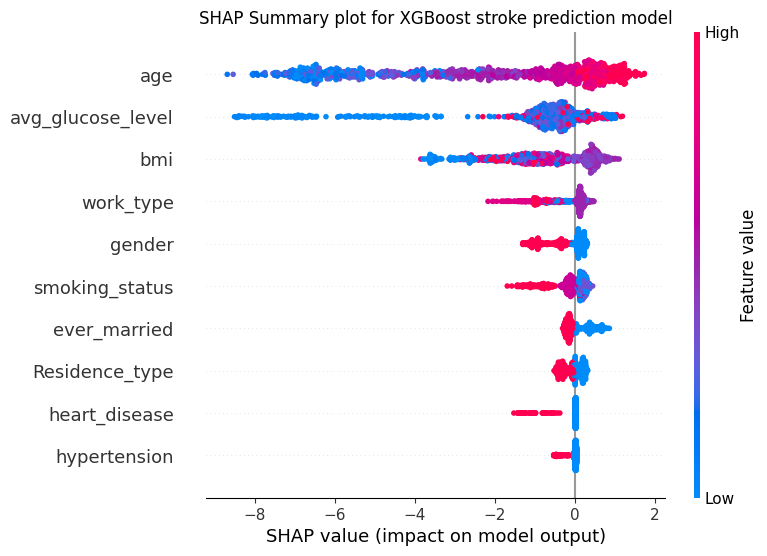

In [39]:
shap.summary_plot(shap_values_xgb, X_test, show=False)
plt.title("SHAP Summary plot for XGBoost stroke prediction model")
plt.show()

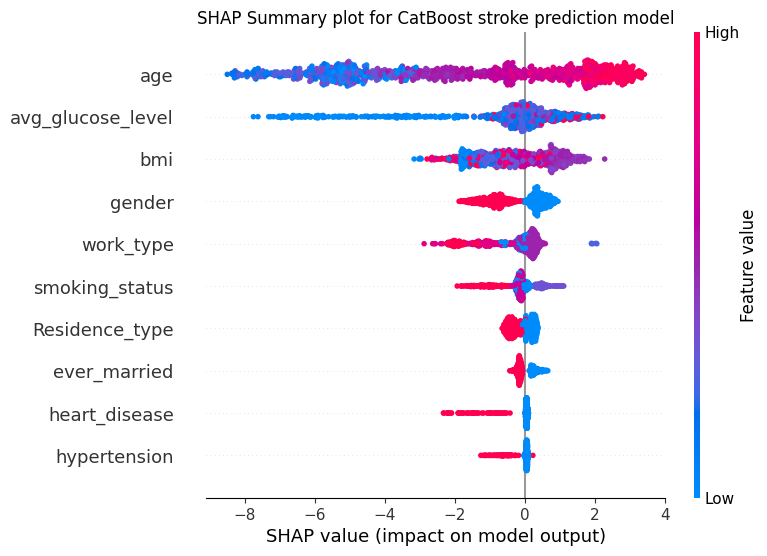

In [40]:
shap.summary_plot(shap_values_cat, X_test, show=False)
plt.title("SHAP Summary plot for CatBoost stroke prediction model")
plt.show()

The SHAP summary plots ranks features according to their average absolute contribution to the model output. Features at the top of the plot, such as age and average glucose level, have the greatest influence on predictions. The color gradient indicates whether high or low feature values increase or decrease predicted stroke risk.

📌 Key Insight

- Higher age and glucose levels consistently increase predicted risk
- Individuals with mid‑range BMI values appear to have a higher risk of stroke than those at either very high or very low BMI levels
- Several categorical variables show weaker or context-dependent influence

### Local Explanation: Individual Prediction

The purpose of local explaination is to know why a specific patient was predicted as high or low risk. In simple words, local explaination tells us which features played an important role (for model) for a specific patient.

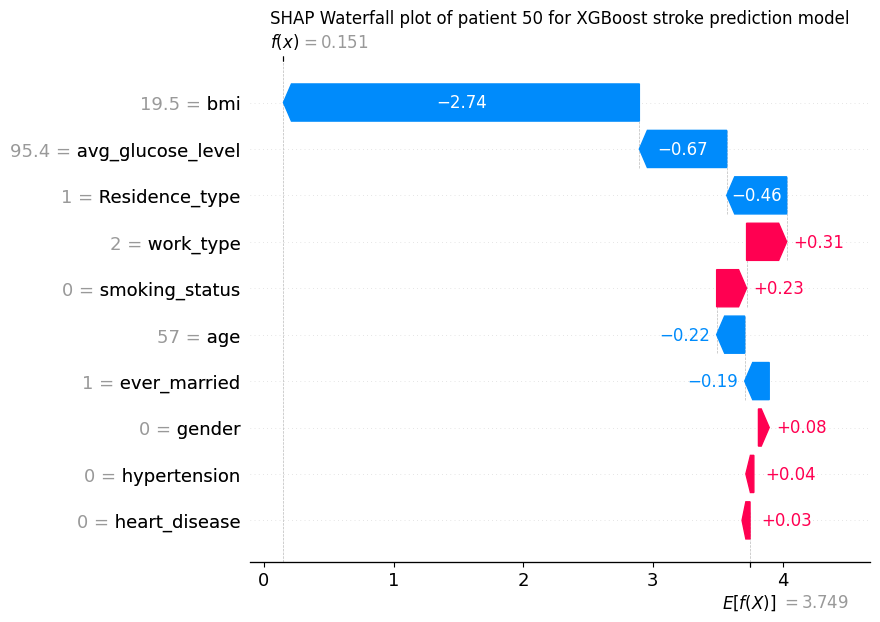

In [41]:
idx = 49
idx_2 = 99

shap.plots.waterfall(shap_values_xgb[idx], show=False)
plt.title("SHAP Waterfall plot of patient 50 for XGBoost stroke prediction model")
plt.show()

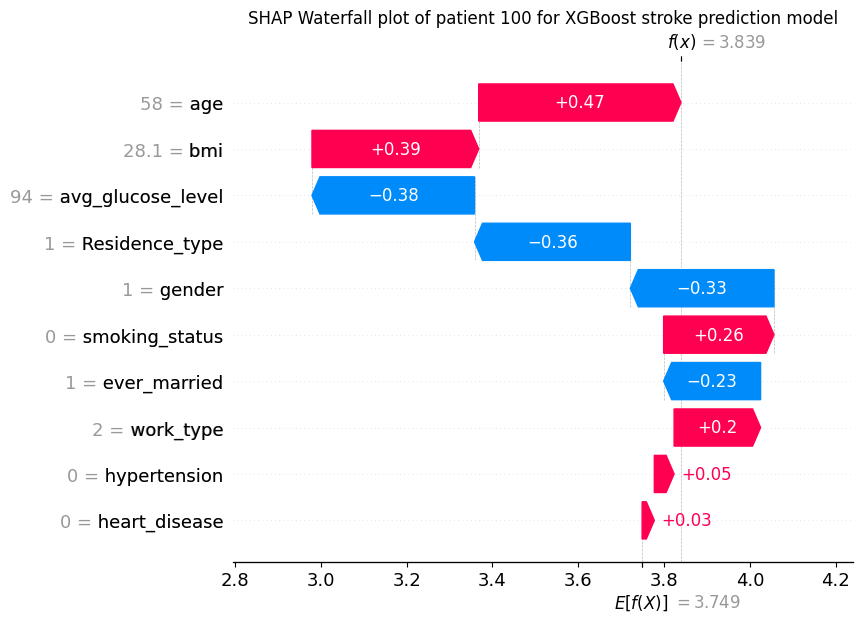

In [42]:
shap.plots.waterfall(shap_values_xgb[idx_2], show=False)
plt.title("SHAP Waterfall plot of patient 100 for XGBoost stroke prediction model")
plt.show()

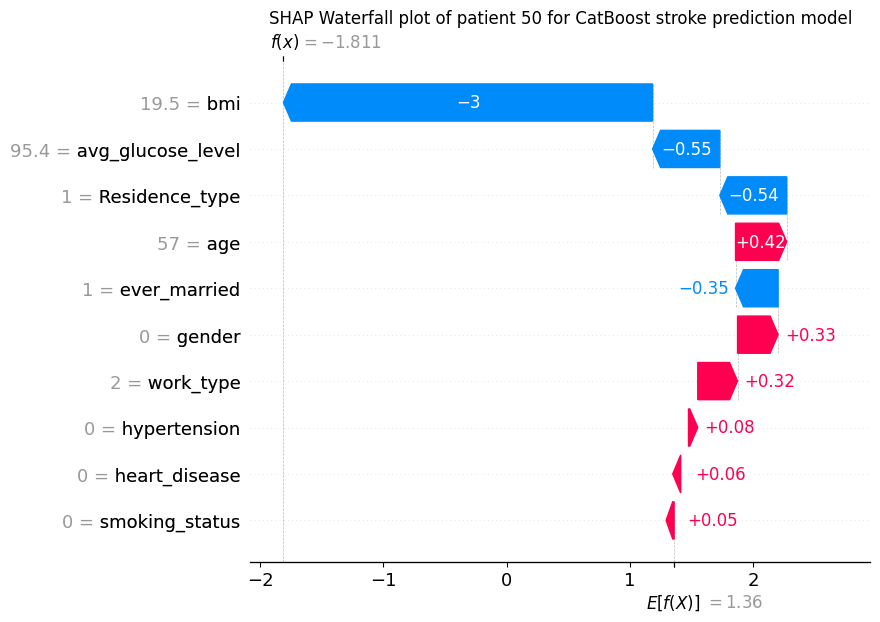

In [43]:
shap.plots.waterfall(shap_values_cat[idx], show=False)
plt.title("SHAP Waterfall plot of patient 50 for CatBoost stroke prediction model")
plt.show()

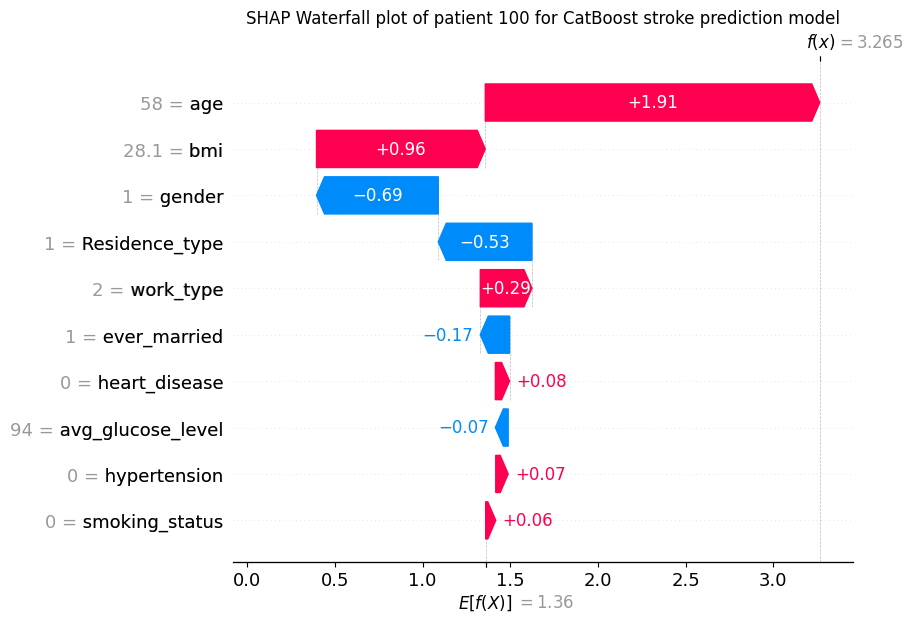

In [44]:
shap.plots.waterfall(shap_values_cat[idx_2], show=False)
plt.title("SHAP Waterfall plot of patient 100 for CatBoost stroke prediction model")
plt.show()

The waterfall plots illustrates how individual feature contributions combine to produce the final prediction. Features pushing the prediction toward higher stroke risk are shown in red, while protective features are shown in blue. This allows for intuitive, patient-level interpretability.

### Feature Effect Analysis (Dependence Plots)

This is to analyze how feature values relate to their SHAP contributions.

#### Influence of Age

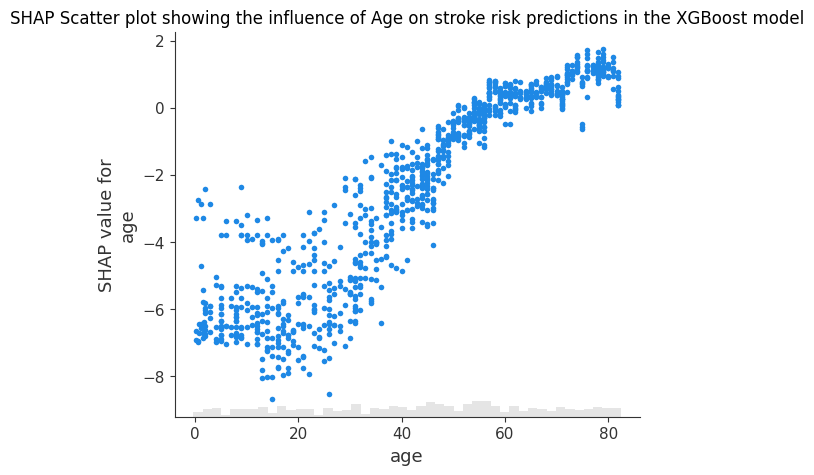

In [45]:
shap.plots.scatter(shap_values_xgb[:, "age"], show=False)
plt.title("SHAP Scatter plot showing the influence of Age on stroke risk predictions in the XGBoost model")
plt.show()

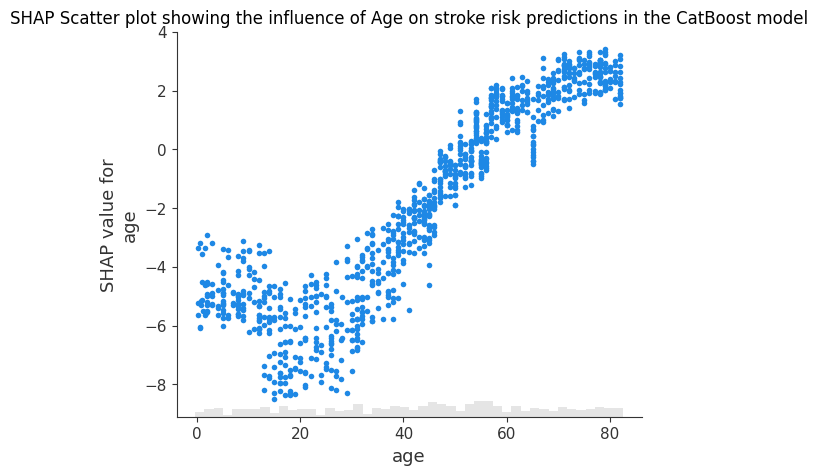

In [46]:
shap.plots.scatter(shap_values_cat[:, "age"], show=False)
plt.title("SHAP Scatter plot showing the influence of Age on stroke risk predictions in the CatBoost model")
plt.show()

The SHAP scatter plots shows how the SHAP value of age changes across its range. Older patients exhibit consistently higher SHAP values, confirming that age is a dominant driver of stroke risk in the model.

#### Influence of Average Glucose Level

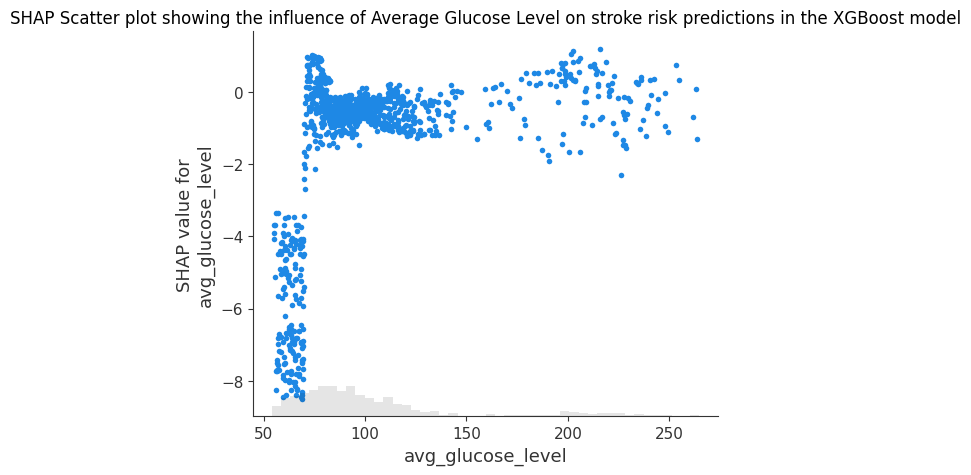

In [47]:
shap.plots.scatter(shap_values_xgb[:, "avg_glucose_level"], show=False)
plt.title("SHAP Scatter plot showing the influence of Average Glucose Level on stroke risk predictions in the XGBoost model")
plt.show()

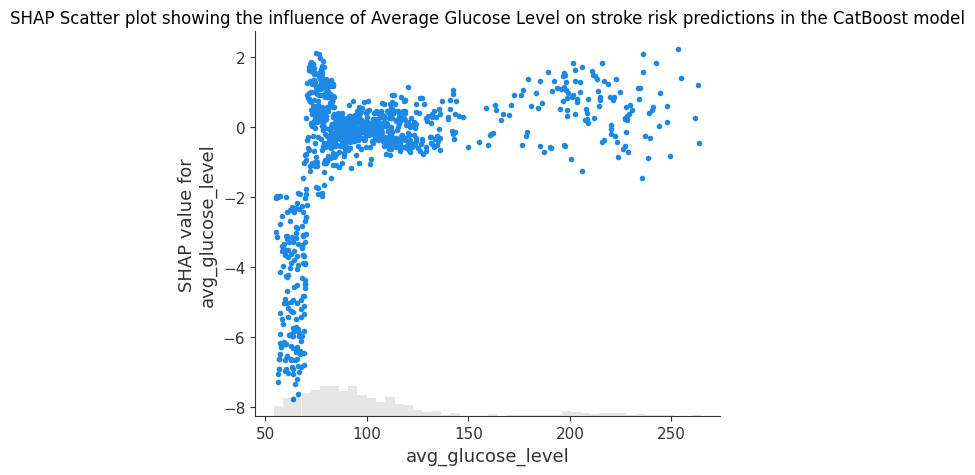

In [48]:
shap.plots.scatter(shap_values_cat[:, "avg_glucose_level"], show=False)
plt.title("SHAP Scatter plot showing the influence of Average Glucose Level on stroke risk predictions in the CatBoost model")
plt.show()

The SHAP scatter plots indicate that lower average glucose levels contribute negatively to stroke risk predictions, while higher glucose values increasingly push the model toward a higher predicted risk. This pattern is consistent across both the CatBoost and XGBoost models, suggesting that average glucose level is a strong and stable risk factor influencing stroke predictions.

#### Influence of Age with Hypertension

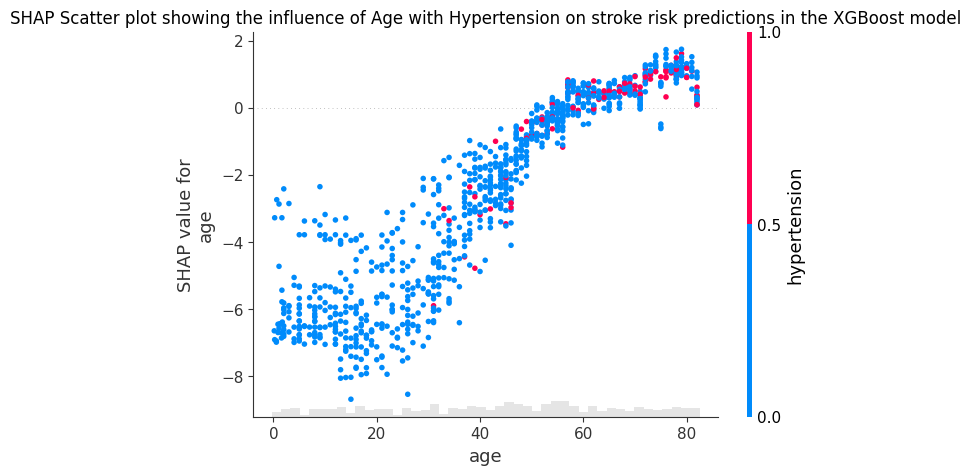

In [49]:
shap.plots.scatter(shap_values_xgb[:, "age"], color=shap_values_xgb[:, "hypertension"], show=False)
plt.title("SHAP Scatter plot showing the influence of Age with Hypertension on stroke risk predictions in the XGBoost model")
plt.show()

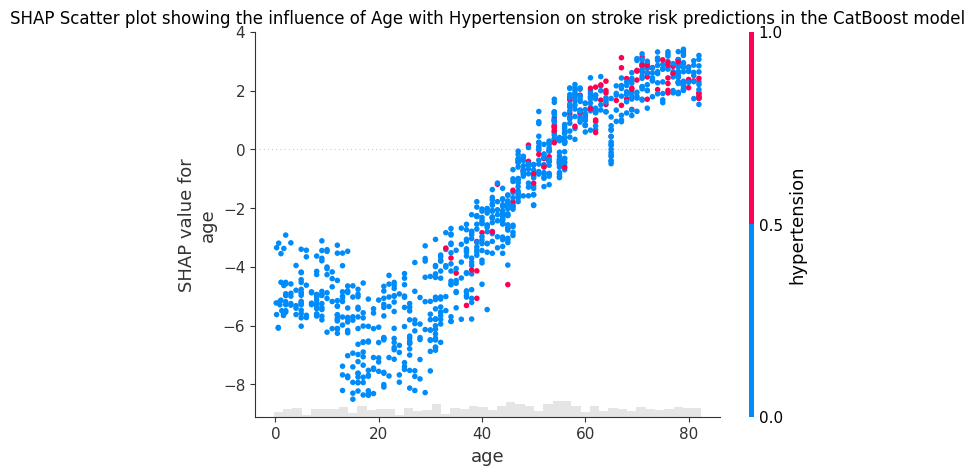

In [50]:
shap.plots.scatter(shap_values_cat[:, "age"], color=shap_values_cat[:, "hypertension"], show=False)
plt.title("SHAP Scatter plot showing the influence of Age with Hypertension on stroke risk predictions in the CatBoost model")
plt.show()

This visualization reveals interactions between age and hypertension, indicating that the effect of age on stroke risk is amplified for patients with hypertension.

#### Influence of Average Glucose Level with Hypertension

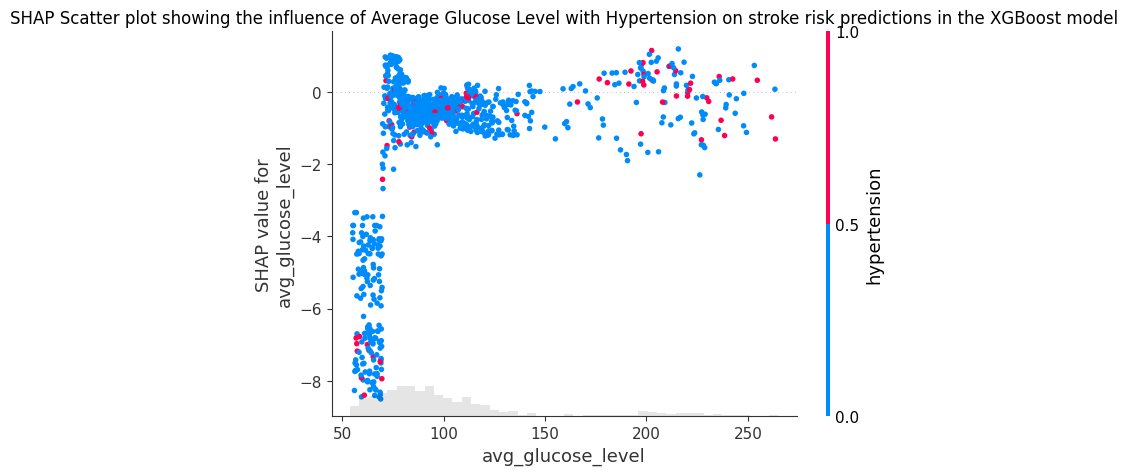

In [51]:
shap.plots.scatter(shap_values_xgb[:, "avg_glucose_level"], color=shap_values_xgb[:, "hypertension"], show=False)
plt.title("SHAP Scatter plot showing the influence of Average Glucose Level with Hypertension on stroke risk predictions in the XGBoost model")
plt.show()

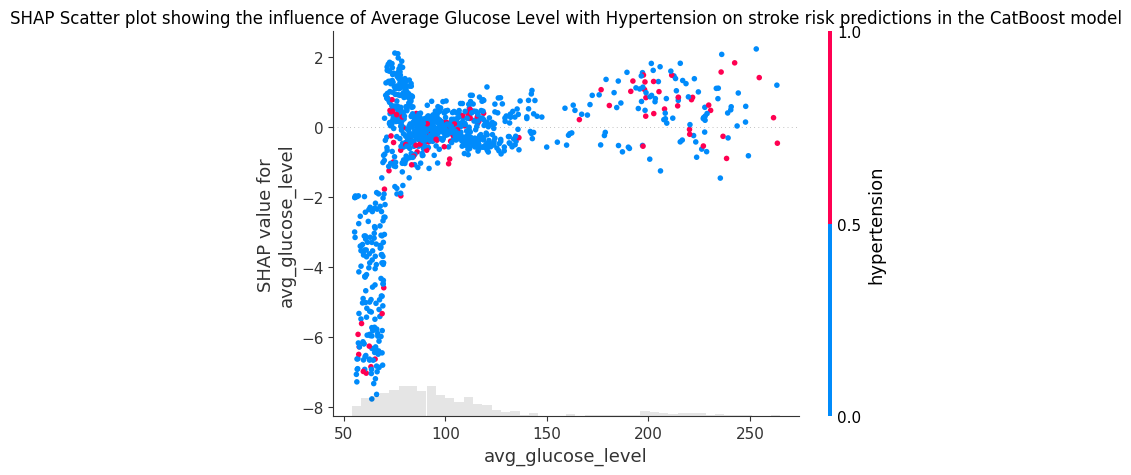

In [52]:
shap.plots.scatter(shap_values_cat[:, "avg_glucose_level"], color=shap_values_cat[:, "hypertension"], show=False)
plt.title("SHAP Scatter plot showing the influence of Average Glucose Level with Hypertension on stroke risk predictions in the CatBoost model")
plt.show()

Elevated glucose levels are the dominant stroke risk predictor in the CatBoost model, with hypertension significantly amplifying this effect.

#### Analysis of Gender

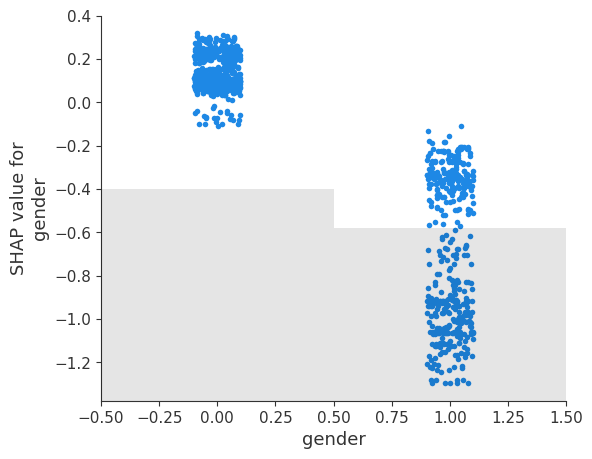

In [56]:
shap.plots.scatter(shap_values_xgb[:, "gender"], show=False)
plt.show()

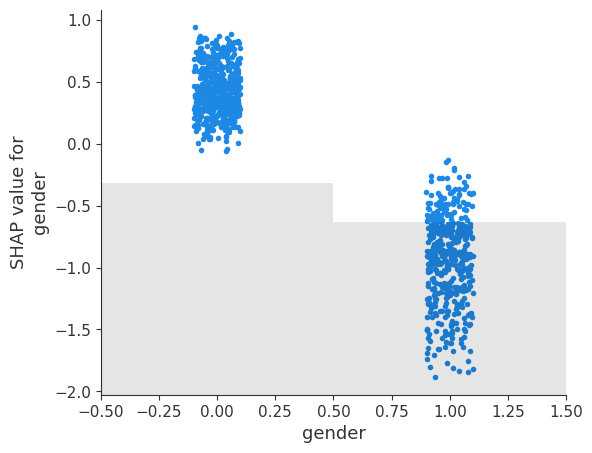

In [57]:
shap.plots.scatter(shap_values_cat[:, "gender"], show=False)
plt.show()

Female patients demonstrate significantly higher gender SHAP values compared to males, suggesting a strong gender bias in the model's predictions. However, this effect is an artifact of independent analysis; when other features are included, gender contributes minimally to the overall stroke risk assessment, as shown in the plot below.

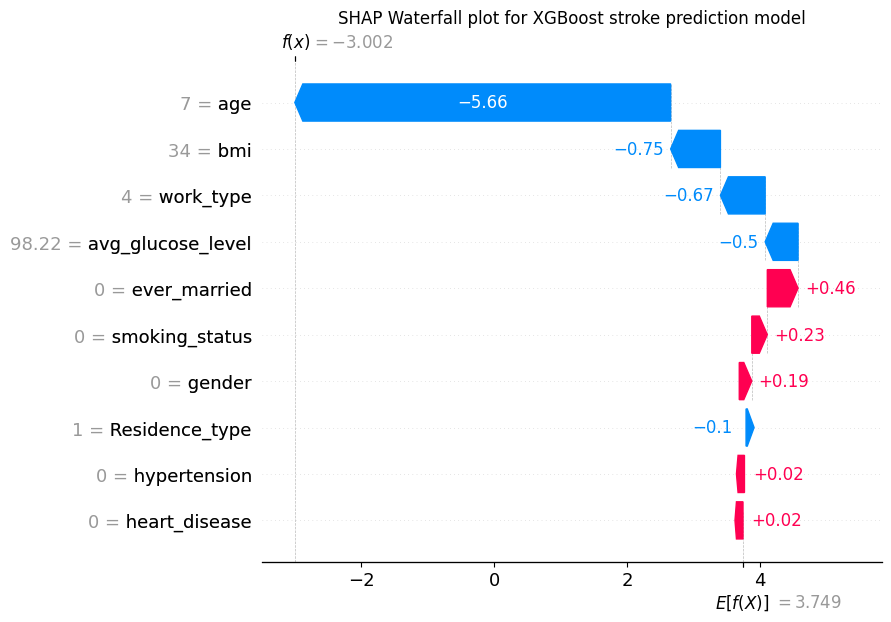

In [58]:
idx = 17

shap.plots.waterfall(shap_values_xgb[idx], show=False)
plt.title("SHAP Waterfall plot for XGBoost stroke prediction model")
plt.show()

While LIME provides local approximations of model behavior using linear surrogate models, SHAP offers explanations grounded in cooperative game theory. SHAP explanations are additive, consistent, and remain stable across different runs. In contrast to LIME, SHAP provides both global and local interpretability without requiring repeated sampling.